# Actividad 1 - Medición Calidad Aire Comunidad de Madrid

---
Adrian Diaz Manzanares - 22016494

Juan Carlos Jimenez Flores - 22059255


Rodrigo Muñoz Pedraza - 22062417

---

Para la realizacion de esta actividad hemos seguido los siguientes pasos:

1.Leemos los datos del csv, el cual nos descargamos de

    https://datos.comunidad.madrid/catalogo/dataset/calidad_aire_datos_mes 

2.Escogemos los datos que nos han parecido mas relevantes, en nuestro caso nos hemos quedado los datos de:

    -Dioxido de azufre
    -Monóxido de carbono
    -Óxidos de nitrógeno
  
 De estos hemos estudiado los valores medios por hora de cada municipio y los valores maximos por hora de cada municipio
 
Una vez teniamos estos datos, los hemos almacenado en una base de datos SQL, en una entidad que sigue el siguiente esquema:


    

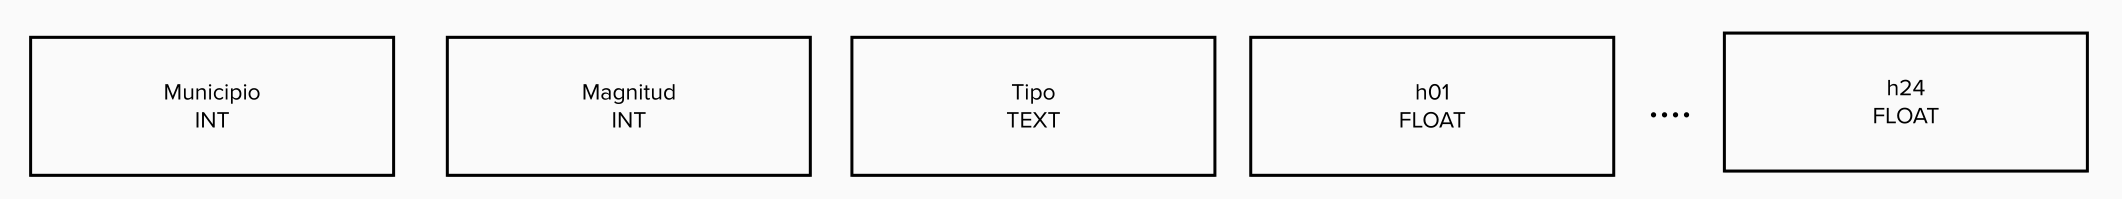

In [67]:
from PIL import Image
import requests
from io import BytesIO

response = requests.get("https://cdn.discordapp.com/attachments/778554776698880000/1029349322325766224/baseDeDatos.png")
img = Image.open(BytesIO(response.content))
img

Por ultimo realizamos la representacion de los datos en las diferentes graficas

# 1.Lectura de datos del csv


In [24]:
import pandas as pd
import numpy as np

Leemos el csv desde su localización

In [27]:
pf = pd.read_csv('../../../data/calidad_aire_datos_mes.csv', sep=';')
df = pd.DataFrame(pf)
df.head()

,provincia,municipio,estacion,magnitud,punto_muestreo,ano,mes,dia,h01,v01,...,h20,v20,h21,v21,h22,v22,h23,v23,h24,v24
0,28,102,1,1,28102001_1_38,2022,9,1,3.0,V,...,2.0,V,3.0,V,2.0,V,2.0,V,2.0,V
1,28,102,1,6,28102001_6_48,2022,9,1,0.3,V,...,0.3,V,0.3,V,0.3,V,0.3,V,0.3,V
2,28,102,1,7,28102001_7_8,2022,9,1,1.0,V,...,1.0,V,1.0,V,1.0,V,1.0,V,1.0,V
3,28,102,1,8,28102001_8_8,2022,9,1,7.0,V,...,6.0,V,7.0,V,5.0,V,5.0,V,5.0,V
4,28,102,1,10,28102001_10_49,2022,9,1,11.0,V,...,16.0,V,12.0,V,12.0,V,9.0,V,10.0,V


# 2. Creacion y carga de los datos seleccionados en la base de datos

In [28]:
import mysql.connector

Añadimos una conexión con nuestros datos

In [30]:
con = mysql.connector.connect(user = "root", password = "root", host = "127.0.0.1")

In [31]:
cursor = con.cursor()
cursor.execute("CREATE DATABASE actividad1;")
cursor.execute('USE actividad1')

createQuery = ''

for col in df.columns:
    if 'municipio' in col:
        createQuery += col + ' INT, '
    if 'magnitud' in col:
        createQuery += col + ' INT, tipo TEXT, '
    if 'h' in col:
        createQuery += col + ' FLOAT, '

cleanQuery = createQuery[0:len(createQuery) - 2]

cursor.execute(f"CREATE TABLE estudio ({cleanQuery});")


In [32]:
#Diccionario con todos los municipios
municipios = {
    5: 'ALCALA DE HENARES',
    6: 'ALCOBENDAS',
    7: 'ALCORCON',
    9: 'ALGETE',
    13: 'ARANJUEZ',
    14: 'ARGANDA DEL REY',
    16:'EL ALTAZAR',
    45: 'COLMENAR VIEJO',
    47: 'COLLADO VILLALBA',
    49: 'COSLADA',
    58: 'FUENLABRADA',
    65: 'GETAFE',
    67: 'GUADALIX DE LA SIERRA',
    74: 'LEGANES',
    80: 'MAJADAHONDA',
    92: 'MOSTOLES',
    102: 'ORUSCO DE TAJUÑA',
    120: 'PUERTO DE COTOS',
    123: 'RIVAS VACIAMADRID',
    133: 'SAN MARTIN DE VALDEIGLESIAS',
    148: 'TORREJON DE ARDOZ',
    161: 'VALDEMORO',
    171: 'VILLA DEL PRADO',
    180: 'VILLAREJO DE SALVANES'
}

La siguiente funcion se encarga de almacenar en la base de datos los valores segun el esquema especificado anteriormente

In [41]:
def uploadToDb(municipio, tipo, mediaMunicipio, magnitud):
    stringArr = ''
    for num in mediaMunicipio.values:
        stringArr += (str(num) + ',')

    stringArr = stringArr[0:len(stringArr) - 1]
    cursor.execute("INSERT INTO estudio(municipio, magnitud, tipo, h01, h02, h03, h04, h05, h06,h07, h08, h09, h10, h11, h12, h13,h14, h15, h16, h17, h18, h19,h20,h21, h22, h23, h24) VALUES ( " + str(municipio) + ',' + str(magnitud ) + ',"' + str(tipo) + '",' + stringArr + ")")
    
    con.commit()
    

Mediante estas funciones, dada la magnitud a estudiarc(Dioxido de azufre, Monóxido de carbono u Óxidos de nitrógeno) podemos obtener la media o el máximo y almacenarlo en la base de datos

In [42]:
def getDataAndUpload(magnitud, tipo):
    data = df[(df['magnitud'] == magnitud)]
    muniIds = data['municipio']
    idMunis = []
    for num in muniIds.values:
        if num not in idMunis:
            idMunis.append(num)
    for muni in idMunis:
        dataMunicipio = data[data['municipio'] == muni]
        if tipo == "media":  
            mediaPorMunicipio = dataMunicipio[['h01','h02','h03','h04','h05','h06','h07','h08','h09','h10','h11','h12','h13','h14','h15','h16','h17','h18','h19','h20','h21','h22','h23','h24']].mean()
        else:
            mediaPorMunicipio = dataMunicipio[['h01','h02','h03','h04','h05','h06','h07','h08','h09','h10','h11','h12','h13','h14','h15','h16','h17','h18','h19','h20','h21','h22','h23','h24']].max()
        uploadToDb(muni, tipo, mediaPorMunicipio,magnitud)


Almacenamiento de datos para el Dioxido de azufre

In [43]:
getDataAndUpload(1, 'media')

In [44]:
getDataAndUpload(1, 'max')

Almacenamiento de datos para el Monóxido de carbono

In [45]:
getDataAndUpload(6, 'media')

In [46]:
getDataAndUpload(6, 'max')

Almacenamiento de datos para Óxidos de nitrógeno

In [47]:
getDataAndUpload(12, 'media')

In [48]:
getDataAndUpload(12, 'max')

# 3.Representacion de los datos

In [49]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [82]:
nombre_magnitudes = {1: "Dioxido de azufre", 6: "Monoxido de carbono", 7: "Monoxido de nitrogeno",
                     8: "Dioxido de nitrogeno", 9: "Particulas en suspension < PM2.5",
                     10: "Particulas en suspension < PM10", 12: "Oxidos de nitrogeno", 14: "Ozono",
                     20: "Tolueno", 22: "Black Carbon", 30: "Benceno", 42: "Hidrocarburos totales",
                     44: "Hidrocarburos no mecanicos", 431: "MetaParaXileno"}

def generarLinePlotMedia(magnitud):
    horas = ["h01", "h02", "h03", "h04", "h05", "h05", "h06",
             "h07", "h08", "h09", "h10", "h11", "h12", "h13",
             "h14", "h15", "h16", "h17", "h18", "h19","h20",
             "h21", "h22", "h23", "h24"]

    data = df[(df['magnitud'] == magnitud)]
    muniIds = data['municipio']
    intH = []
    for h in horas:
        intH.append(int(h.split("h")[1]))

    npHoras = np.array(intH)
    idMunis = []
    for num in muniIds.values:
        if num not in idMunis:
            idMunis.append(num)
    sns.set(rc={'figure.figsize':(10,7)})
    for muni in idMunis:
        dataMunicipio = data[data['municipio'] == muni]
        mediaPorMunicipio = dataMunicipio[horas].mean()
        col = (np.random.random(), np.random.random(), np.random.random())
        sns.lineplot(x = npHoras, y = mediaPorMunicipio.values, color=col, label = municipios[muni]).set(title="Media de datos por municipio del " + nombre_magnitudes[magnitud]) 


In [69]:
def generarLinePlotMax(magnitud):
    horas = ["h01", "h02", "h03", "h04", "h05", "h05", "h06",
             "h07", "h08", "h09", "h10", "h11", "h12", "h13",
             "h14", "h15", "h16", "h17", "h18", "h19","h20",
             "h21", "h22", "h23", "h24"]

    data = df[(df['magnitud'] == magnitud)]
    muniIds = data['municipio']
    intH = []
    for h in horas:
        intH.append(int(h.split("h")[1]))

    npHoras = np.array(intH)
    idMunis = []
    for num in muniIds.values:
        if num not in idMunis:
            idMunis.append(num)
    sns.set(rc={'figure.figsize':(10,7)})
    for muni in idMunis:
        dataMunicipio = data[data['municipio'] == muni]
        mediaPorMunicipio = dataMunicipio[horas].max()
        col = (np.random.random(), np.random.random(), np.random.random())
        sns.lineplot(x = npHoras, y = mediaPorMunicipio.values, color=col, label = municipios[muni]).set(title="Máximos de datos por municipio del " + nombre_magnitudes[magnitud])

In [70]:
def generarScatterMedia(magnitud):
    horas = ["h01", "h02", "h03", "h04", "h05", "h05", "h06",
             "h07", "h08", "h09", "h10", "h11", "h12", "h13",
             "h14", "h15", "h16", "h17", "h18", "h19","h20",
             "h21", "h22", "h23", "h24"]

    data = df[(df['magnitud'] == magnitud)]
    muniIds = data['municipio']
    intH = []
    for h in horas:
        intH.append(int(h.split("h")[1]))

    npHoras = np.array(intH)
    idMunis = []
    for num in muniIds.values:
        if num not in idMunis:
            idMunis.append(num)

    for muni in idMunis:
        dataMunicipio = data[data['municipio'] == muni]
        mediaPorMunicipio = dataMunicipio[horas].mean()
        col = (np.random.random(), np.random.random(), np.random.random())
        plt.title("Media de datos por municipio del " + nombre_magnitudes[magnitud])
        plt.scatter(x = npHoras, y = mediaPorMunicipio, color=col, label = municipios[muni])
        plt.legend(loc="center right", bbox_to_anchor=(1.4, 0.5))

In [71]:
def generarScatterMax(magnitud):
    horas = ["h01", "h02", "h03", "h04", "h05", "h05", "h06",
             "h07", "h08", "h09", "h10", "h11", "h12", "h13",
             "h14", "h15", "h16", "h17", "h18", "h19","h20",
             "h21", "h22", "h23", "h24"]

    data = df[(df['magnitud'] == magnitud)]
    muniIds = data['municipio']
    intH = []
    for h in horas:
        intH.append(int(h.split("h")[1]))

    npHoras = np.array(intH)
    idMunis = []
    for num in muniIds.values:
        if num not in idMunis:
            idMunis.append(num)

    for muni in idMunis:
        dataMunicipio = data[data['municipio'] == muni]
        mediaPorMunicipio = dataMunicipio[horas].max()
        col = (np.random.random(), np.random.random(), np.random.random())
        plt.title("Máximo de datos por municipio del " + nombre_magnitudes[magnitud])
        plt.scatter(x = npHoras, y = mediaPorMunicipio, color=col, label = municipios[muni])
        plt.legend(loc="center right", bbox_to_anchor=(1.4, 0.5))

## Diagramas Dióxido de azufre

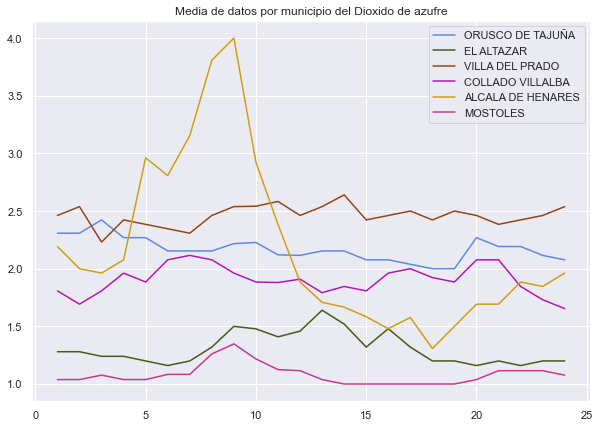

In [83]:
generarLinePlotMedia(1)

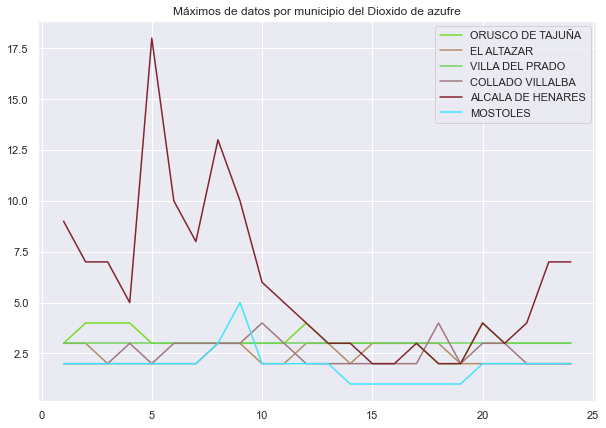

In [95]:
generarLinePlotMax(1)

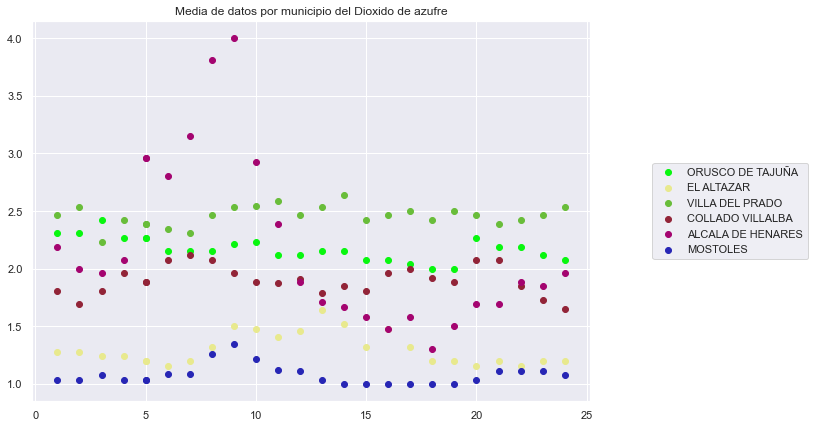

In [85]:
generarScatterMedia(1)

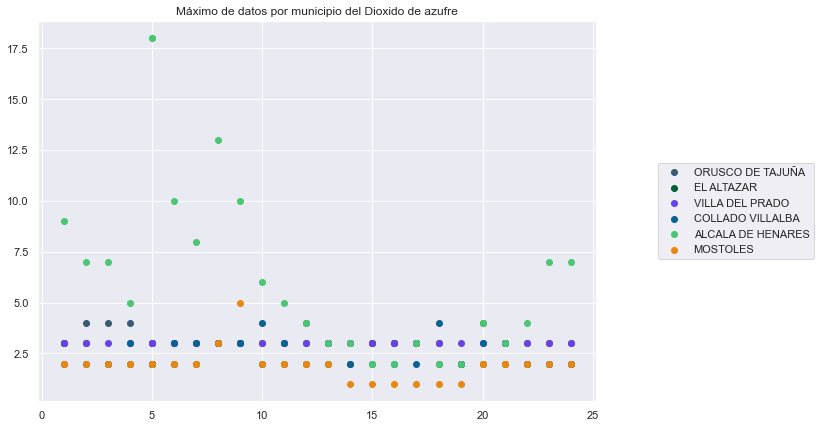

In [98]:
generarScatterMax(1)

## Diagramas de Monóxido de carbono

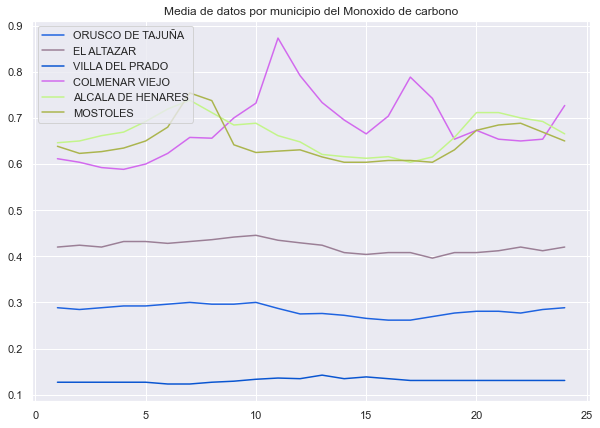

In [101]:
generarLinePlotMedia(6)

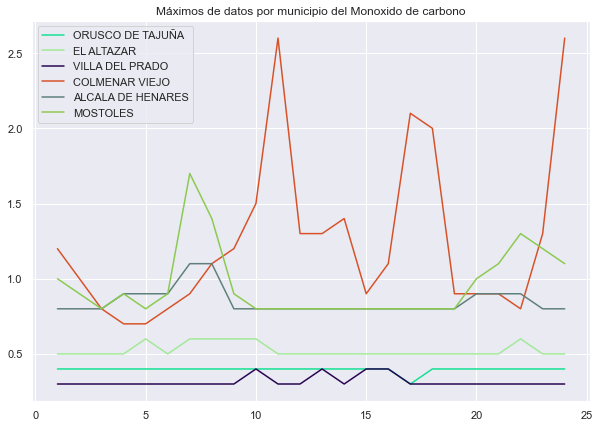

In [100]:
generarLinePlotMax(6)

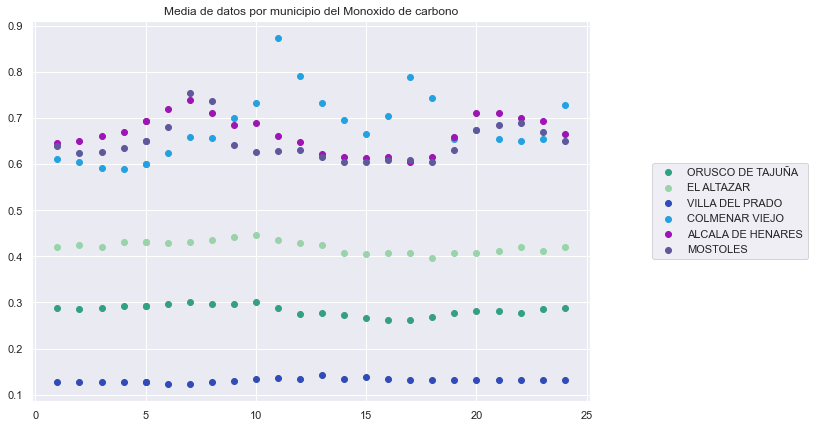

In [89]:
generarScatterMedia(6)

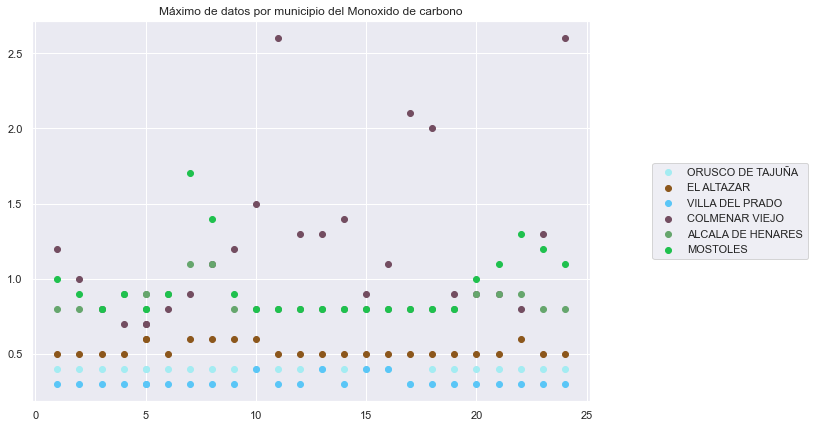

In [90]:
generarScatterMax(6)

## Diagramas de Óxidos de nitrógeno

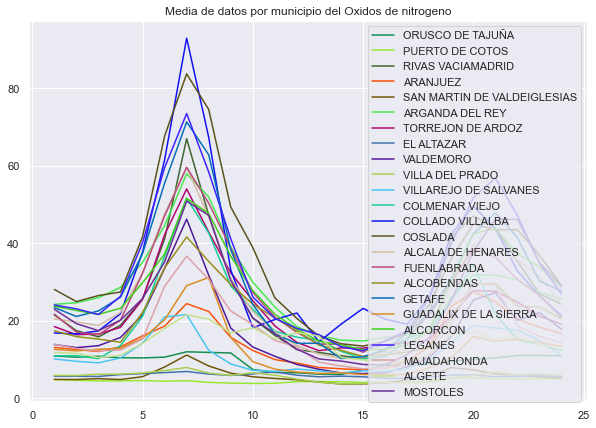

In [91]:
generarLinePlotMedia(12)

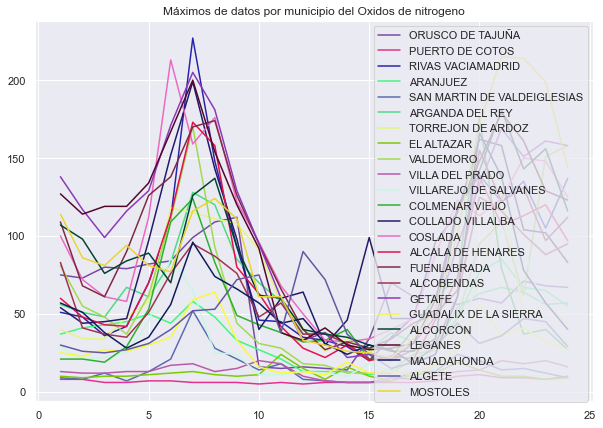

In [92]:
generarLinePlotMax(12)

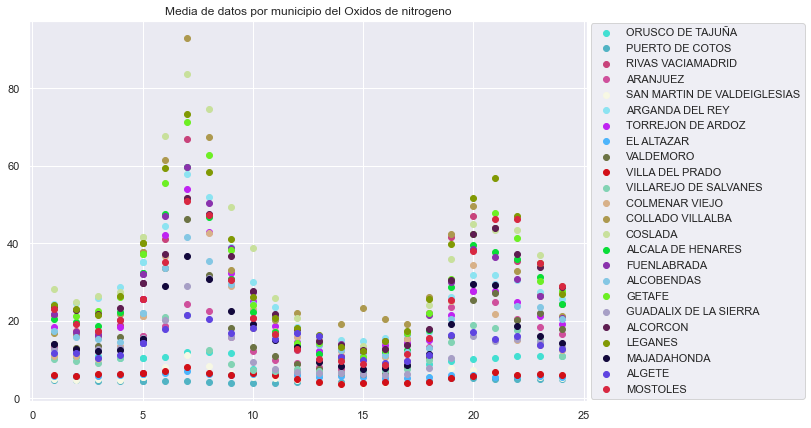

In [93]:
generarScatterMedia(12)

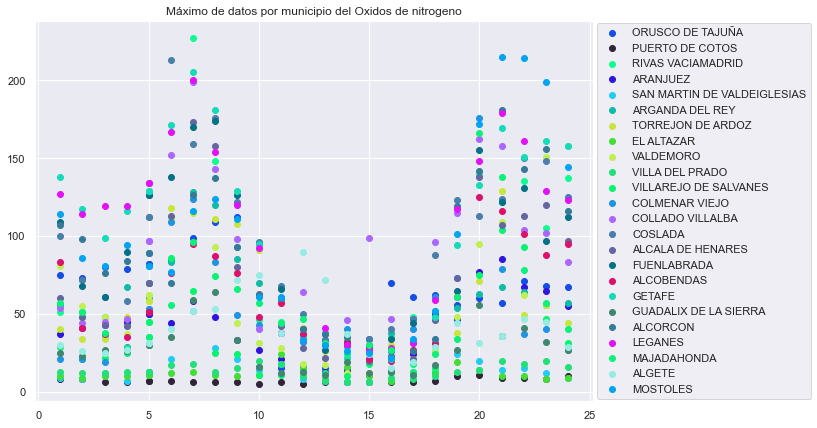

In [94]:
generarScatterMax(12)

# Conclusión

### • Dioxido de azufre
Como podemos observar en las gráficas, el municipio en el que más se produce dióxido de azufre es en **Alcalá de Henares** alcanzando una media de 4 µg/m³ a las 9 horas y un máximo de 18 µg/m³ a las 5 horas. A pesar de esto, a partir de las 9 horas decrementan las cantidades de dióxido de azufre emitidas.
Destacamos Villa del Prado que mantiene una media de 2.5 µg/m³ las 24 horas.

### • Monóxido de carbono
Como podemos observar en las gráficas, el municipio en el que más se produce monóxido de carbono es en **Colmenar Viejo** alcanzando una media de 0.9 mg/m³ a las 11 horas y un máximo de 2.6 mg/m³ a las 9 horas. Además podemos observar que las horas puntas de emisión son las 11, 17 y 24 horas.

### • Óxidos de nitrógeno
Como podemos observar en las gráficas, el municipio en el que más se produce óxido de nitrógeno es en **Collado Villalba** alcanzando una media de 97 µg/m³ y máximo de 230 µg/m³ a las 8 horas. Todos los municipios emiten su máximo a las 8 horas, su segundo máximo a las 22 horas y su mínimo a las 15 horas.


Finalmente, tras analizar los datos teniendo en cuenta las tres medidas, podemos afirmar que el municipio que más contamina en general es **Alcalá de Henares**.  
    
    • Media dióxido de azufre: 4 µg/m³ 
    • Máximo dióxido de azufre: 18 µg/m³  
    
    • Media monóxido de carbono: 0.7 mg/m³  
    • Máximo monóxido de carbono: 1.1 mg/m³  
    
    • Media óxidos de nitrógeno: 60 µg/m³  
    • Máximo óxidos de nitrógeno: 180 µg/m³  